In [56]:
%reload_ext autoreload
%autoreload 2

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import utils_notebook as un

import importlib
importlib.reload(un)

from fink_filters.filter_on_axis_grb.filter import bronze_events, silver_events, gold_events

## Load data

In [3]:
fink_grb_data_path = "/user/julien.peloton/fink_grb/"

grb_obs = ["Fermi", "SWIFT", "INTEGRAL"]

In [4]:
gcn = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_storage/raw"]).toPandas()
gcn = gcn.sort_values("triggerTimejd")
gcn = gcn[gcn["observatory"].isin(grb_obs)]

# Online

In [5]:
ztf_online = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_x_ztf/online"]).toPandas()

In [6]:
merge_online = gcn.merge(ztf_online, on = "triggerId")

In [7]:
print("Nb events with ztf counterparts: {}".format(len(merge_online["triggerId"].unique())))

Nb events with ztf counterparts: 5


In [8]:
print(merge_online.groupby(["observatory_x", "instrument_x", "triggerTimeUTC_x", "triggerId"]).count()["objectId"].to_markdown())

|                                                                        |   objectId |
|:-----------------------------------------------------------------------|-----------:|
| ('Fermi', 'GBM', Timestamp('2023-06-19 12:26:17.100000'), '708863182') |        179 |
| ('Fermi', 'GBM', Timestamp('2023-06-26 09:00:14.130000'), '709455619') |        452 |
| ('Fermi', 'GBM', Timestamp('2023-06-30 02:50:33.820000'), '709779038') |          2 |
| ('Fermi', 'GBM', Timestamp('2023-06-30 10:34:01.950000'), '709806846') |         71 |
| ('Fermi', 'GBM', Timestamp('2023-07-03 09:47:58.120000'), '710063283') |          9 |


## On sky distribution

In [9]:
merge_online.columns

Index(['observatory_x', 'instrument_x', 'event_x', 'ivorn', 'triggerId', 'ra',
       'dec', 'err_arcmin', 'ackTime', 'triggerTimejd', 'triggerTimeUTC_x',
       'raw_event', 'year_x', 'month_x', 'day_x', 'objectId', 'candid',
       'ztf_ra', 'ztf_dec', 'fid', 'jdstarthist', 'rb', 'jd', 'instrument_y',
       'event_y', 'observatory_y', 'grb_ra', 'grb_dec', 'grb_loc_error',
       'triggerTimeUTC_y', 'grb_proba', 'fink_class', 'delta_mag', 'rate',
       'from_upper', 'start_vartime', 'diff_vartime', 'timestamp', 'year_y',
       'month_y', 'day_y'],
      dtype='object')

In [10]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

In [29]:
uniqueGRB = merge_online.drop_duplicates("triggerId")

In [33]:
uniqueGRB.observatory_x.unique()

array(['Fermi'], dtype=object)

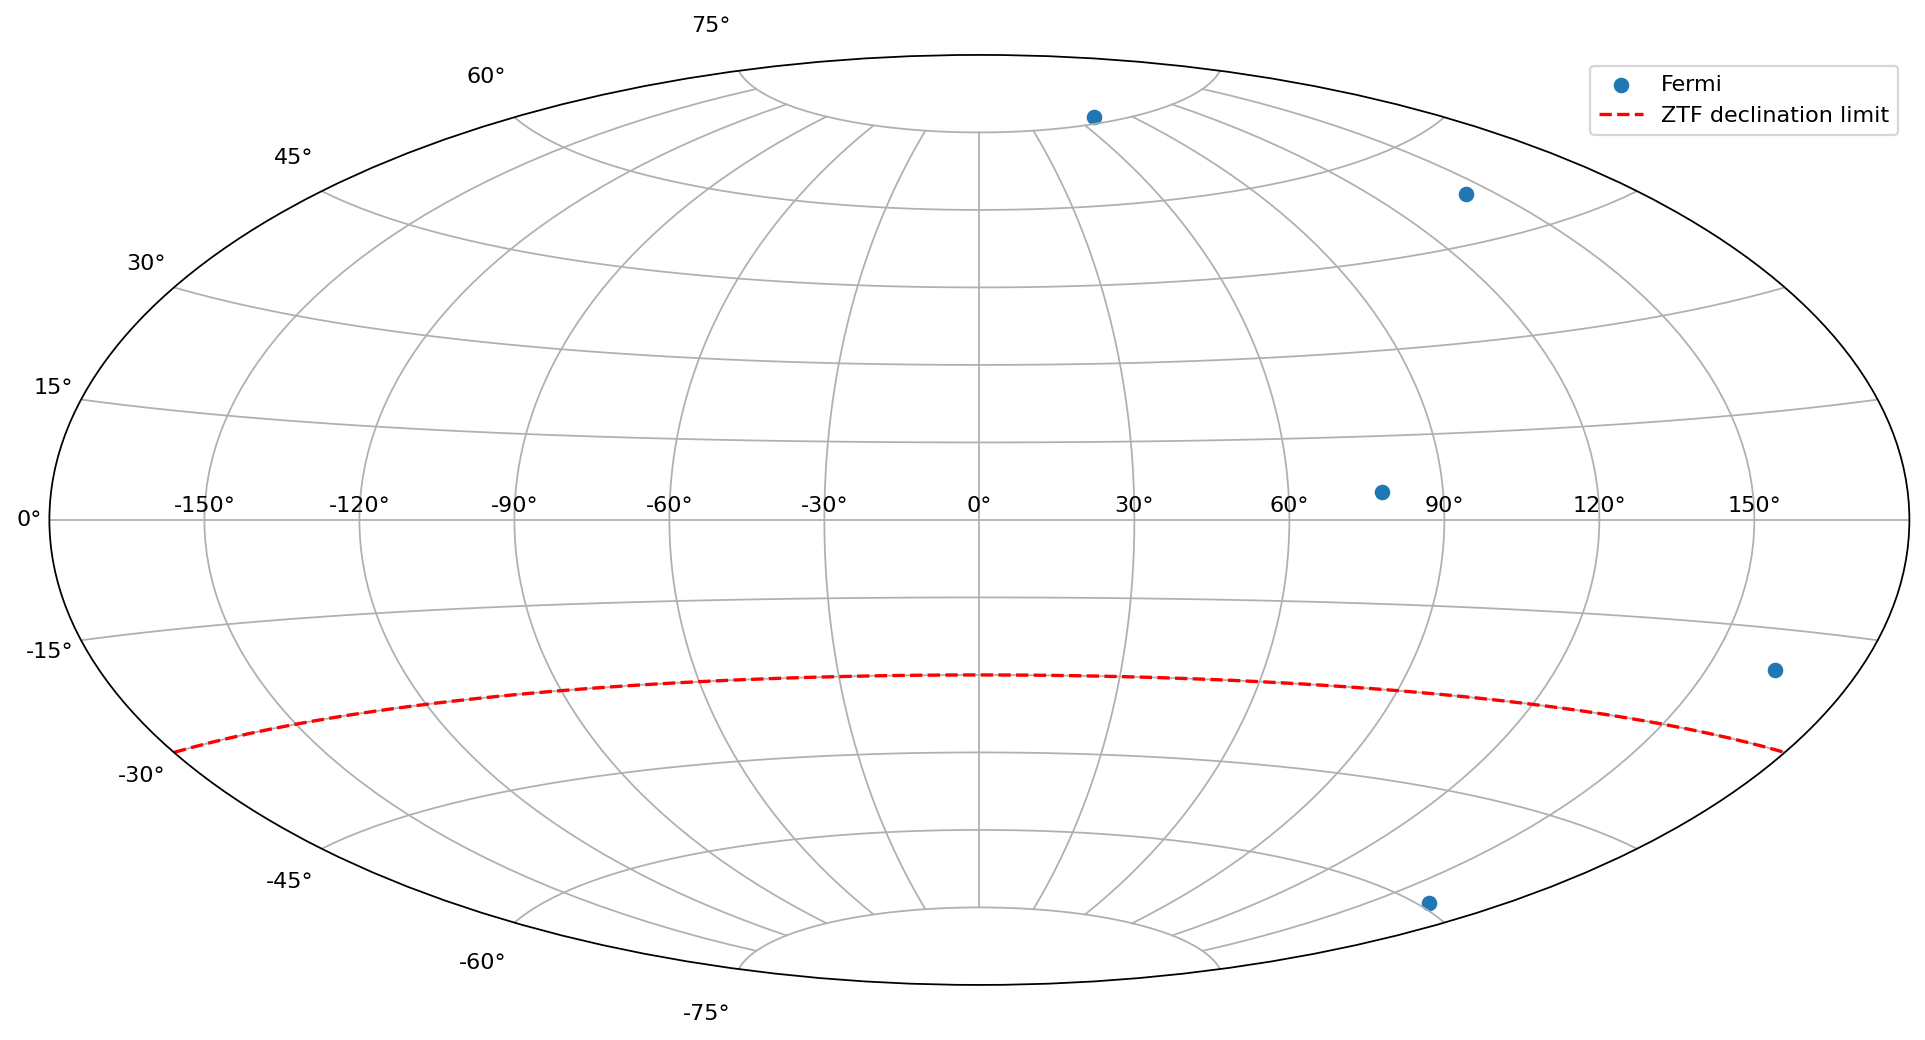

In [44]:
plt.figure(figsize=(15, 15), dpi=160)
plt.subplot(111, projection='aitoff')
plt.grid(True)
for obs in uniqueGRB.observatory_x.unique():
    tmp_pdf = uniqueGRB[uniqueGRB["observatory_x"] == obs]
    eq = SkyCoord(tmp_pdf.grb_ra, tmp_pdf.grb_dec, unit=u.deg)
    gal = eq.galactic
    
    plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, label=obs)
    plt.axhline(y=np.radians(-30), color='r', linestyle='--', label="ZTF declination limit")
    plt.legend()
    plt.show()

## Event analysis

In [69]:
eventId = "709806846"

In [70]:
event_pdf = merge_online[merge_online["triggerId"] == eventId]

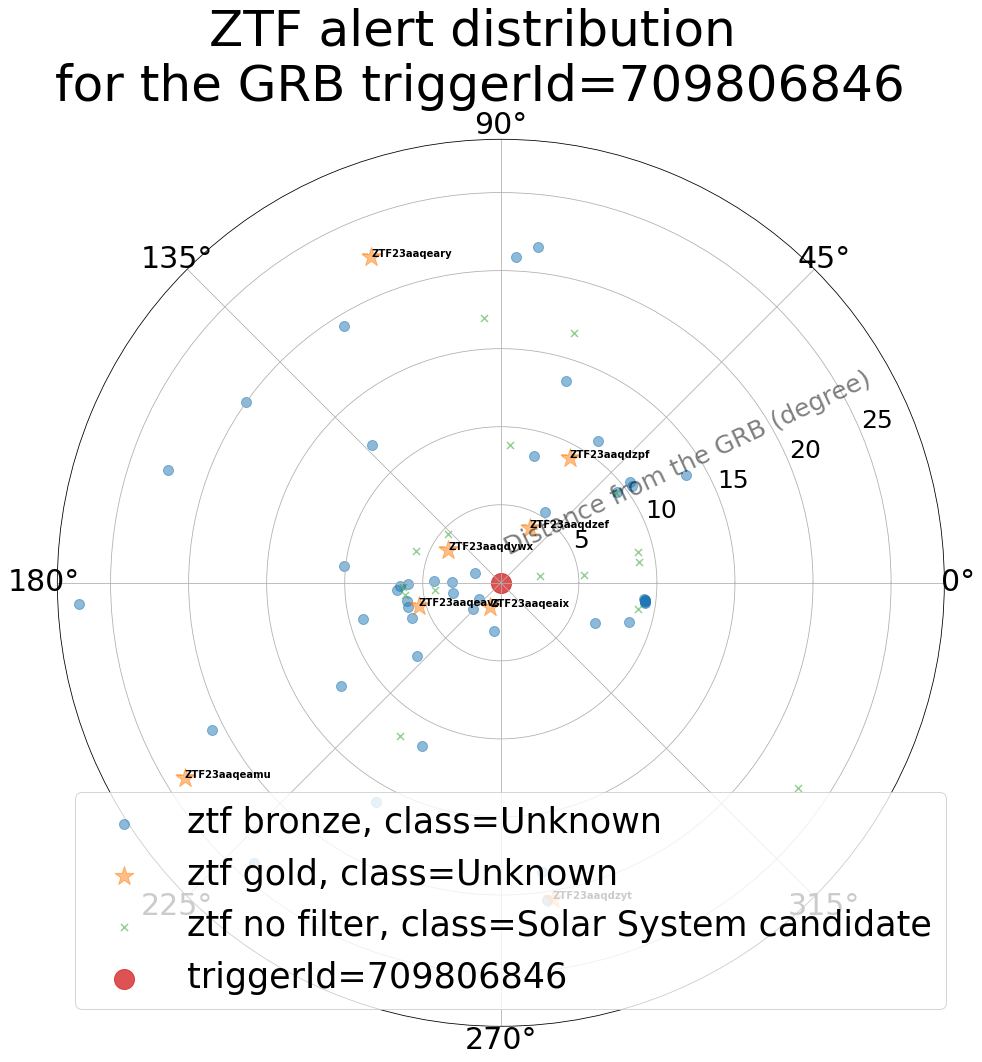

In [71]:
un.plot_ztf_join_distribution(event_pdf, eventId)

In [63]:
gold, silver = un.get_gold_and_silver(event_pdf)

In [65]:
gold

,observatory_x,instrument_x,event_x,ivorn,triggerId,ra,dec,err_arcmin,ackTime,triggerTimejd,...,fink_class,delta_mag,rate,from_upper,start_vartime,diff_vartime,timestamp,year_y,month_y,day_y
664,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-1.659809,-0.839224,1.0,2.460126e+06,0.0,2023-06-30 08:37:30.000000,2023,6,30
667,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-3.012466,-1.505754,1.0,2.460126e+06,0.0,2023-06-30 08:41:14.000636,2023,6,30
680,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-3.084948,-1.544333,1.0,2.460126e+06,0.0,2023-06-30 08:34:04.998738,2023,6,30
686,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-2.006565,-1.016018,1.0,2.460126e+06,0.0,2023-06-30 08:34:46.004148,2023,6,30
690,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-2.032364,-0.692665,1.0,2.460126e+06,0.0,2023-06-30 08:35:27.000949,2023,6,30
691,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-2.074444,-1.050388,1.0,2.460126e+06,0.0,2023-06-30 08:34:46.004148,2023,6,30
698,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-2.514259,-1.271247,1.0,2.460126e+06,0.0,2023-06-30 08:37:30.000000,2023,6,30
700,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Flt_Pos_2023-06-...,709806846,301.95,41.95,1569.0,2023-06-30 12:34:33.184910,2.460126e+06,...,Unknown,-1.953907,-0.988648,1.0,2.460126e+06,0.0,2023-06-30 08:36:07.004152,2023,6,30
